In [1]:
import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = torchvision.datasets.CIFAR10('./data', train=True, download=True, 
                                           transform=transform)
cifar_test = torchvision.datasets.CIFAR10('./data', train=False, download=True, 
                                          transform=transform)

train_sliceable = [(x, y) for x, y in cifar_train]
test_sliceable = [(x, y) for x, y in cifar_test]


channels, width, height = cifar_train[0][0].size()

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 8

trainloader = torch.utils.data.DataLoader(train_sliceable[:40000], batch_size=batch_size,
                                          num_workers=2)
valloader = torch.utils.data.DataLoader(train_sliceable[40000:], batch_size=batch_size,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(test_sliceable, batch_size=batch_size,
                                          num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class CifarCNN(nn.Module):
    
    def __init__(self):
        super(CifarCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=channels, 
                               out_channels=20, kernel_size=5,
                               stride=2, padding=2)
        self.conv2 = nn.Conv2d(in_channels=20, 
                               out_channels=50, kernel_size=5,
                               stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=50, 
                               out_channels=80, kernel_size=3,
                               stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=80, 
                               out_channels=100, kernel_size=3,
                               stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(100 * 2 * 2, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 80)
        self.fc4 = nn.Linear(80, 10)
        
    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = x.view(-1, 100 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = CifarCNN()
model_path = './best_dnn.tar'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_losses = []
val_losses = []
eval_freq = 500
num_evals = 0
best_num_evals = 0
patience = 5 * eval_freq
early_stop = False

for epoch in range(7):
    
    running_loss = 0.0
    val_iters_improved = 0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics and early stopping every 500 examples
        running_loss += loss.item()
        if i % eval_freq == eval_freq - 1:
            num_evals += 1
            
            # evaluate average validation loss
            running_val_loss = 0.0
            for val_data in valloader:
                val_inputs, val_labels = val_data
                val_outputs = model(val_inputs)
                val_loss = nn.CrossEntropyLoss()(val_outputs, val_labels)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss / 10000) 
            
            # compute average training loss
            train_losses.append(running_loss / (eval_freq * batch_size))
            running_loss = 0.0
            
            # print statistics
            print('[%d, %5d] train loss: %.3f\tval loss: %.3f' %
                  (epoch + 1, i + 1, train_losses[-1], val_losses[-1]))
            
            # save model params if validation loss went down
            val_iters_improved += eval_freq
            if min(val_losses) == val_losses[-1]:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_path)
                val_iters_improved = 0
                best_num_evals = num_evals
                
            # load older model and end training 
            elif val_iters_improved > patience:
                print('Eraly stopping criterion reached')
                checkpoint = torch.load(model_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                epoch = checkpoint['epoch']
                loss = checkpoint['loss']
                num_evals = best_num_evals
                early_stop = True
                
        # break if we have seen early stopping criterion
        if early_stop:
            break

print('Finished Training')

[1,   500] train loss: 0.481	val loss: 0.297
[1,  1000] train loss: 0.295	val loss: 0.294
[1,  1500] train loss: 0.293	val loss: 0.292
[1,  2000] train loss: 0.291	val loss: 0.291
[1,  2500] train loss: 0.291	val loss: 0.286
[1,  3000] train loss: 0.283	val loss: 0.271
[1,  3500] train loss: 0.266	val loss: 0.262
[1,  4000] train loss: 0.254	val loss: 0.245
[1,  4500] train loss: 0.243	val loss: 0.235
[1,  5000] train loss: 0.235	val loss: 0.229
[2,   500] train loss: 0.229	val loss: 0.229
[2,  1000] train loss: 0.222	val loss: 0.219
[2,  1500] train loss: 0.218	val loss: 0.222
[2,  2000] train loss: 0.217	val loss: 0.211
[2,  2500] train loss: 0.212	val loss: 0.203
[2,  3000] train loss: 0.203	val loss: 0.200
[2,  3500] train loss: 0.201	val loss: 0.199
[2,  4000] train loss: 0.197	val loss: 0.200
[2,  4500] train loss: 0.198	val loss: 0.193
[2,  5000] train loss: 0.193	val loss: 0.194
[3,   500] train loss: 0.189	val loss: 0.193
[3,  1000] train loss: 0.186	val loss: 0.184
[3,  1500]

Text(0, 0.5, 'Log-Loss')

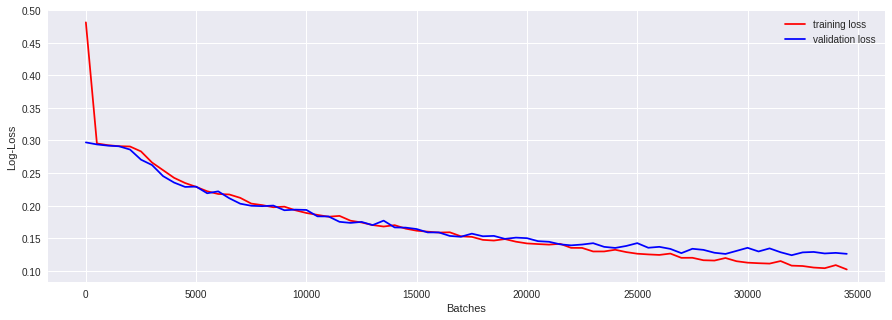

In [16]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(0, num_evals * eval_freq, eval_freq), 
         train_losses[0:num_evals], color='r', marker='|')
plt.plot(np.arange(0, num_evals * eval_freq, eval_freq), 
         val_losses[0:num_evals], color='b', marker='|')
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Batches')
plt.ylabel('Log-Loss')

In [17]:
# Evaluate Validation accuracy
running_correct = 0
for data in valloader:
    inputs, labels = data
    outputs = model(inputs)
    _, preds = nn.Softmax(dim=1)(outputs).max(1)
    correct = torch.sum(torch.eq(preds, labels))
    
    running_correct += correct
    
print('Validation Acc: %.3f' % 
      (running_correct.item() / 10000))
    

Validation Acc: 0.644


In [18]:
# Evaluate Test accuracy
running_correct = 0
for data in testloader:
    inputs, labels = data
    outputs = model(inputs)
    _, preds = nn.Softmax(dim=1)(outputs).max(1)
    correct = torch.sum(torch.eq(preds, labels))
    
    running_correct += correct
    
print('Test Acc: %.3f' % 
      (running_correct.item() / 10000))

Test Acc: 0.641
